In [169]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

llm = ChatGroq(model="qwen-qwq-32b")

## Building The Vector db

In [170]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma, FAISS
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [171]:
urls = [
    "https://langchain-ai.github.io/langgraph/",
    "https://modelcontextprotocol.io/introduction",
    "https://langchain-ai.github.io/langgraph/agents/multi-agent/"
]

In [172]:
docs = [WebBaseLoader(url).load() for url in urls]
len(docs)

3

In [173]:
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

doc_splits = text_splitter.split_documents(documents=doc_list)
print(doc_splits[1:3])

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/', 'title': 'LangGraph', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='Deployment\n    \n  \n\n\n\n\n\n\n\n\n\n    Prebuilt agents\n    \n  \n\n\n\n\n\n            Prebuilt agents\n          \n\n\n\n\n    Overview\n    \n  \n\n\n\n\n\n    Running agents\n    \n  \n\n\n\n\n\n    Streaming\n    \n  \n\n\n\n\n\n    Models\n    \n  \n\n\n\n\n\n    Tools\n    \n  \n\n\n\n\n\n    MCP Integration\n    \n  \n\n\n\n\n\n    Context\n    \n  \n\n\n\n\n\n    Memory\n    \n  \n\n\n\n\n\n    Human-in-the-loop\n    \n  \n\n\n\n\n\n    Multi-agent\n    \n  \n\n\n\n\n\n    Evals\n    \n  \n\n\n\n\n\n    Deployment\n    \n  \n\n\n\n\n\n    UI\n    \n  \n\n\n\n\n\n\n\n\n\n    LangGraph framework\n    \n  \n\n\n\n\n\n            LangGraph framework\n          \n\n\n\n\n    Agent architectures\n    \n  \n\n\n\n\n\n\n    Graphs\n    \n  \n\n\n\n\n\n\n    Streaming\n    

In [174]:
embeddings = HuggingFaceBgeEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [175]:

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

langGraph_retriever = vectorstore.as_retriever()

In [176]:
# query = "Why multi agent is important?"

# response = langGraph_retriever.invoke(query)
# response

In [177]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="general",

)

In [178]:
# tavily_search.invoke("What is the capita of Bangladesh?")

In [179]:
# response_s = tavily_search.invoke("What is the capita of Bangladesh?")
# response_s['results']

In [180]:
# response_s['results'][0]['content']

In [181]:
# type(response_s)

## Now define the Graph State

In [182]:
from typing import TypedDict, List, Literal, Dict
from pydantic import BaseModel, Field

class CragState(TypedDict):
    """the"""
    question: str = Field(description="This is the user query.")
    context: str =Field(description="This is the retrieve data form vector store based on the user query.")
    response: str = Field(description="its model generated response based on the user query and context.")
    s_docs : str = Field(default=None, description="This the list of document of the vector context similarity search chunk of data.")
    grade: Literal['yes', 'no']
    pol_ques: str = None

In [183]:
def formate_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [184]:
def retrieve(state: CragState):
    """THis is the function is responsible for to retrieve the document based on the user query."""
    query = state['question']
    
    response = langGraph_retriever.invoke(query)
    context = formate_docs(response)
    
    return {
        "context": context
    }
    
    

In [185]:
## schema
class Grade(BaseModel):
    """This is produce binary output based on the document if relevant then sya yes otherwise say no."""
    binary_output: Literal["yes", "no"] = Field(description="if the document is relevant to the query then say yes otherwise say no")

In [186]:
from langchain_core.messages import HumanMessage, SystemMessage

def grade_document(state: CragState) ->Literal["yes", "no"]:
    """This function is response for the grade the document like retrieve document is relevant to the question or not."""
    context= state['context']
    question = state['question']
    system_msg = f"""Your task is to check where the retrieve context is relevant with the question or not. if relevant then just say yes otherwise say no
                        this question is: {question} \n
                    this context is: \n\n
                    {context} \n\n
                    carefully analysis the context and question and produced the output based on the schema.
                    """
    llm_with_str_op = llm.with_structured_output(Grade)
    
    response = llm_with_str_op.invoke([SystemMessage(content=system_msg)])
    print(response.binary_output)
    return {
        "grade": response.binary_output
    }




In [187]:
def route_node(state: CragState):
    print("reoute node")
    """This function is responsible for the route the node where transform query of generate the response"""
    
    if state['grade'] == 'yes':
        print("the query is relevant.")
        return "generate"
    else:
        print("This query is not relevant.")
        return "transform_query"

In [ ]:


def transform_query(state: CragState):
    """This function is responsible for polishing the user query for better result generation"""
    print("transform query")
    user_query = state['question']
    
    system_msg = f"This is the current user query: {user_query}\nThis query may not be capable of retrieving relevant content from the vectorDB. Please update or polish the query to get the best response."
    
    response = llm.invoke([SystemMessage(content=system_msg)])
    print(f"Polished query: {response.content}")
    
    return {'pol_ques': response.content}

In [189]:
def web_search(state: CragState):
    print("web serarch")
    """This function is responsible for retrieve data form the web based on the query."""
    query = state['pol_ques']
    response = tavily_search.invoke(query)
    
    return {
        "s_docs": response
    }

In [ ]:

    
def generate(state: CragState):
    """This function generates the response based on the context and query."""
    print("generate")
    
    # Check if pol_ques exists in the state
    if 'pol_ques' in state and state['pol_ques']:
        print("--web content--")
        question = state['pol_ques']
        context = state.get('s_docs', '')
    else:
        print("--vectordb context--")
        question = state["question"]
        context = state.get('context', '')
    
    system_msg = f"""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question} 
    Context: {context} 
    Answer:
    """
    
    result = llm.invoke([SystemMessage(content=system_msg)])
    print(result)
    
    return {"response": result.content}

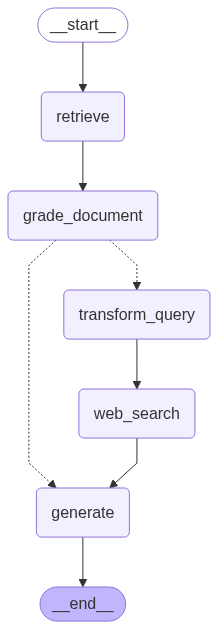

In [191]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

builder = StateGraph(CragState)

builder.add_node("retrieve", retrieve)
builder.add_node("grade_document", grade_document)
builder.add_node("transform_query", transform_query)
builder.add_node("web_search", web_search)
builder.add_node("generate", generate)

## define the edge
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "grade_document")
builder.add_conditional_edges(
    "grade_document",
    route_node,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    },
)
builder.add_edge("transform_query", "web_search")
builder.add_edge("web_search", "generate")
builder.add_edge("generate", END)

graph = builder.compile()

## displaying
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [193]:
graph.invoke(
    {
        "question": "what is the capital of banglades?"
    }
)

no
reoute node
This query is not relevant.
transform query
Polished query: 
<think>
Okay, the user asked "what is the capital of banglades?" with a typo in "Bangladesh". First, I need to correct the spelling of the country's name to ensure accurate results. The correct spelling is "Bangladesh". Then, the capital of Bangladesh is Dhaka, which is a well-known fact. However, the user mentioned that their query might not retrieve relevant content from the vectorDB. Maybe the typo caused an issue. To improve the query, I should first correct "banglades" to "Bangladesh" and rephrase the question for clarity. That way, the system can better match it with existing data. Let me confirm the capital again to be sure. Yes, Dhaka is the capital. So the polished query should be "What is the capital of Bangladesh?" which should yield the correct answer without any issues.
</think>

The capital of Bangladesh is Dhaka. To ensure accurate retrieval from a database or knowledge base, the query should be 

{'question': 'what is the capital of banglades?',
 'context': '\u200bGet started\nChoose the path that best fits your needs:\n\u200bQuick Starts\nFor Server DevelopersGet started building your own server to use in Claude for Desktop and other clientsFor Client DevelopersGet started building your own client that can integrate with all MCP serversFor Claude Desktop UsersGet started using pre-built servers in Claude for Desktop\n\u200bExamples\nExample ServersCheck out our gallery of official MCP servers and implementationsExample ClientsView the list of clients that support MCP integrations\n\u200bTutorials\nBuilding MCP with LLMsLearn how to use LLMs like Claude to speed up your MCP developmentDebugging GuideLearn how to effectively debug MCP servers and integrationsMCP InspectorTest and inspect your MCP servers with our interactive debugging toolMCP Workshop (Video, 2hr)\n\u200bExplore MCP\nDive deeper into MCP’s core concepts and capabilities:\n\nWas this page helpful?\n      \n\n\n\n